In [ ]:
# 2A Plot Jaccard index between the different species

"""
For this part we are going to read all the .standardised.species reports and simply read the number of species and compute a table with the total number of species and the jaccard index
"""

def get_n_species(sample, mode, profiler):
    if profiler in ['kaiju']:
        prefix = 'results'
    elif profiler in ['krakenuniq', 'kraken2', 'ganon']:
        prefix = 'report'
    elif profiler in ['centrifuge']:
        prefix = 'kreport'
    elif profiler in ['kmcp']:
        prefix = 'profile'


    pass0_df = pd.read_csv(f'{RESULTS_DIR}/profiling/{profiler}/pass0/{sample}_mode{mode}/{sample}_mode{mode}.{prefix}.standardised.species', sep='\t')
    pass2_df = pd.read_csv(f'{RESULTS_DIR}/profiling/{profiler}/pass2/{sample}_mode{mode}/{sample}_mode{mode}.{prefix}.standardised.species', sep='\t')

    pass0_n_species = len(pass0_df)
    pass2_n_species = len(pass2_df)
    jaccard_index = len(np.intersect1d(pass0_df['taxonomy_id'].values, pass2_df['taxonomy_id'].values)) / len(np.union1d(pass0_df['taxonomy_id'].values, pass2_df['taxonomy_id'].values))

    return pass0_n_species, pass2_n_species, jaccard_index


dict_n_species = {'profiler': [],
                  'mode': [],
                  'pass 0 species': [],
                  'pass 2 species': [],
                  'jaccard': []}

for profiler in LIST_PROFILERS:
    for mode in range(1,10):
        try:
            pass0_n_species, pass2_n_species, jaccard_index = get_n_species('ARTIFICIAL', mode, profiler)
            dict_n_species['profiler'].append(profiler)
            dict_n_species['mode'].append(mode)
            dict_n_species['pass 0 species'].append(pass0_n_species)
            dict_n_species['pass 2 species'].append(pass2_n_species)
            dict_n_species['jaccard'].append(jaccard_index)
        except:
            print(f'No entry added for profiler {profiler} and mode {mode}')

df_n_species = pd.DataFrame(dict_n_species)


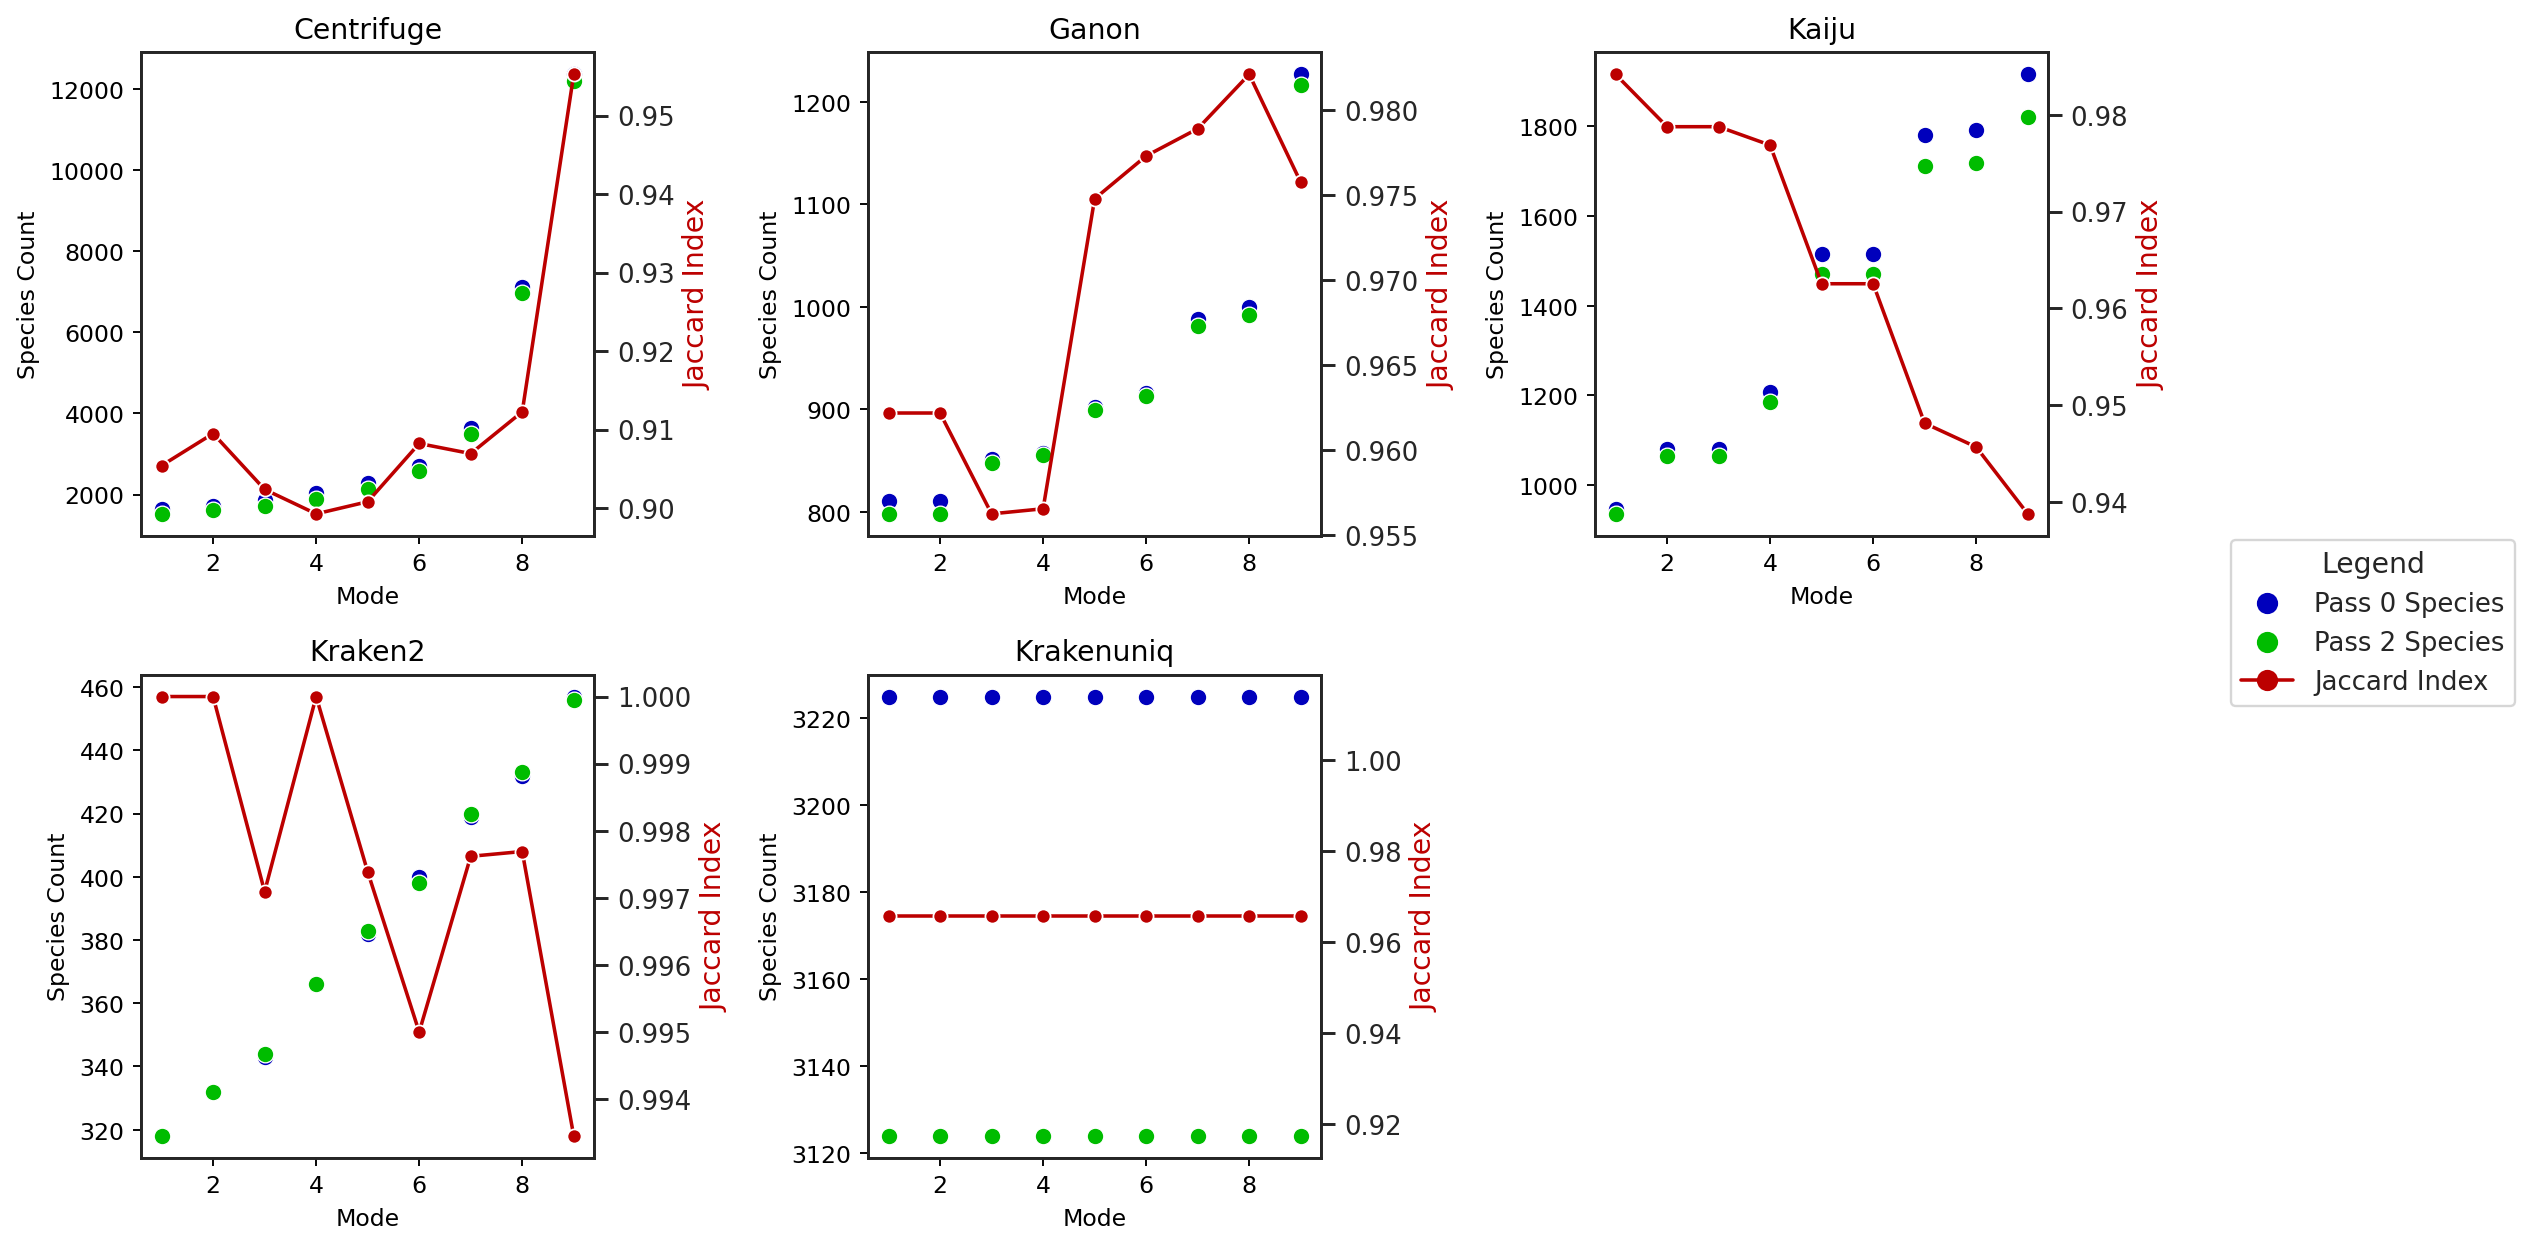

In [ ]:
# Initialize a 3x2 grid for subplots
fig, axes = plt.subplots(2, 3, figsize=(13, 7.5))
axes = axes.flatten()

# Set Seaborn style
sns.set_theme(style="white")

# Define custom labels for the shared legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='#0000bc', label='Pass 0 Species', markersize=8, linestyle='None'),
    plt.Line2D([0], [0], marker='o', color='#00bc00', label='Pass 2 Species', markersize=8, linestyle='None'),
    plt.Line2D([0], [0], marker='o', color='#bc0000', label='Jaccard Index', markersize=8, linestyle='-')
]

# Plot for each profiler
for i, profiler in enumerate(LIST_PROFILERS):
    df_profiler = df_n_species[df_n_species['profiler'] == profiler]
    ax1 = axes[i]
    
    # Scatter plots for `pass 0 species` and `pass 2 species`
    sns.scatterplot(
        data=df_profiler, x='mode', y='pass 0 species', ax=ax1, color='#0000bc', s=50
    )
    sns.scatterplot(
        data=df_profiler, x='mode', y='pass 2 species', ax=ax1, color='#00bc00', s=50
    )
    
    sns.set_theme(style="white")
    
    # Configure the primary y-axis
    ax1.set_xlabel('Mode')
    ax1.set_ylabel('Species Count', color='black')
    #ax1.set_yscale('log')  # Optional: Log scale
    ax1.set_title(f'{profiler.capitalize()}')
    
    # Create a secondary y-axis for Jaccard index
    ax2 = ax1.twinx()
    sns.lineplot(
        data=df_profiler, x='mode', y='jaccard', ax=ax2, color='#bc0000', marker='o'
    )
    ax2.set_ylabel('Jaccard Index', color='#bc0000')

# Hide unused axes
for j in range(len(LIST_PROFILERS), len(axes)):
    axes[j].axis('off')

# Add a shared legend
fig.legend(
    handles=legend_elements, loc='center right', frameon=True, title="Legend", bbox_to_anchor=(1.15, 0.5)
)

plt.tight_layout()
plt.show()

In [ ]:
# 2B) Plot the ratio of abundances
def get_species_details(sample, mode, profiler):
    # Determine the prefix based on the profiler
    if profiler in ['kaiju']:
        prefix = 'results'
    elif profiler in ['krakenuniq', 'kraken2', 'ganon']:
        prefix = 'report'
    elif profiler in ['centrifuge']:
        prefix = 'kreport'
    elif profiler in ['kmcp']:
        prefix = 'profile'
    
    # Read pass0 and pass2 dataframes
    pass0_df = pd.read_csv(
        f'{RESULTS_DIR}/profiling/{profiler}/pass0/{sample}_mode{mode}/{sample}_mode{mode}.{prefix}.standardised.species', 
        sep='\t'
    )
    pass2_df = pd.read_csv(
        f'{RESULTS_DIR}/profiling/{profiler}/pass2/{sample}_mode{mode}/{sample}_mode{mode}.{prefix}.standardised.species', 
        sep='\t'
    )

    # Merge the data on taxonomy_id to align species
    merged_df = pd.merge(
        pass0_df[['name', 'count']].rename(columns={'count': 'pass0'}),
        pass2_df[['name', 'count']].rename(columns={'count': 'pass2'}),
        on='name',
        how='inner'
    )
    
    # Remove human
    merged_df = merged_df[merged_df['name'] != 'Homo sapiens']

    # Calculate ratio and mean
    merged_df['ratio'] = merged_df['pass0'] / merged_df['pass2']
    merged_df['mean'] = merged_df[['pass0', 'pass2']].mean(axis=1)
    
    # Add profiler and mode columns for context
    merged_df['profiler'] = profiler
    merged_df['mode'] = mode
    
    return merged_df[['profiler', 'mode', 'name', 'pass0', 'pass2', 'ratio', 'mean']]

# Initialize a list to hold all data
detailed_data = []

# Loop through each profiler and mode
for profiler in LIST_PROFILERS:
    for mode in range(1, 10):
        try:
            # Get the detailed DataFrame
            df_details = get_species_details('ARTIFICIAL', mode, profiler)
            detailed_data.append(df_details)
        except Exception as e:
            print(f'No entry for profiler {profiler} and mode {mode}: {e}')

# Combine all data into a single DataFrame
df_detailed = pd.concat(detailed_data, ignore_index=True)

In [ ]:
df_detailed[(df_detailed['mode'] == 5) & (df_detailed['name'] == "Rotavirus C")]

,profiler,mode,name,pass0,pass2,ratio,mean
7047,centrifuge,5,Rotavirus C,250001,249971,1.000,249986.000
36841,ganon,5,Rotavirus C,252500,280696,0.900,266598.000
46100,kaiju,5,Rotavirus C,249132,249081,1.000,249106.500
55406,kraken2,5,Rotavirus C,239047,239215,0.999,239131.000
70346,krakenuniq,5,Rotavirus C,250001,249971,1.000,249986.000


In [ ]:
pass2_df

NameError: name 'pass2_df' is not defined

In [ ]:
idx = (pass0_df['mean_norm'] > 300) & (pass2_df['mean_norm'] > 300)
fig, axs = plt.subplots(1,6, figsize=(18, 3))


# Iterate through profilers and calculate Pearson correlation and RMSE
for i, profiler in enumerate(LIST_PROFILERS + ['mean']):
    # Extract values for pass 0 and pass 2
    p0counts = np.log10(1 + np.clip(pass0_df.loc[idx, f'{profiler}_norm'].values, 0, None))
    p2counts = np.log10(1 + np.clip(pass2_df.loc[idx, f'{profiler}_norm'].values, 0, None))

    # Filter out NaN values
    valid_mask = ~np.isnan(p0counts) & ~np.isnan(p2counts)
    p0counts = p0counts[valid_mask]
    p2counts = p2counts[valid_mask]

    # Plot vertical line
    axs[i].plot([1, 6], [1, 6], c='#bc0000', linestyle='--', linewidth=1.5)

    # Scatterplot
    sns.scatterplot(x=p0counts, y=p2counts, ax=axs[i])

    # Calculate Pearson correlation
    corr, _ = pearsonr(p0counts, p2counts)

    # Calculate RMSE (Root Mean Squared Error)
    rmse = np.sqrt(np.mean((p0counts - p2counts) ** 2))

    print(profiler, corr, rmse)

    # Set axis titles
    axs[i].set_title(profiler)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

plt.tight_layout()

/tmp/ipykernel_21865/1988592292.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mode['logmean'] = np.log10(df_mode['mean'])
/tmp/ipykernel_21865/1988592292.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mode['logratio'] = np.log10(df_mode['ratio'])
/tmp/ipykernel_21865/1988592292.py:25: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
/tmp/ipykernel_21865/1988592292.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

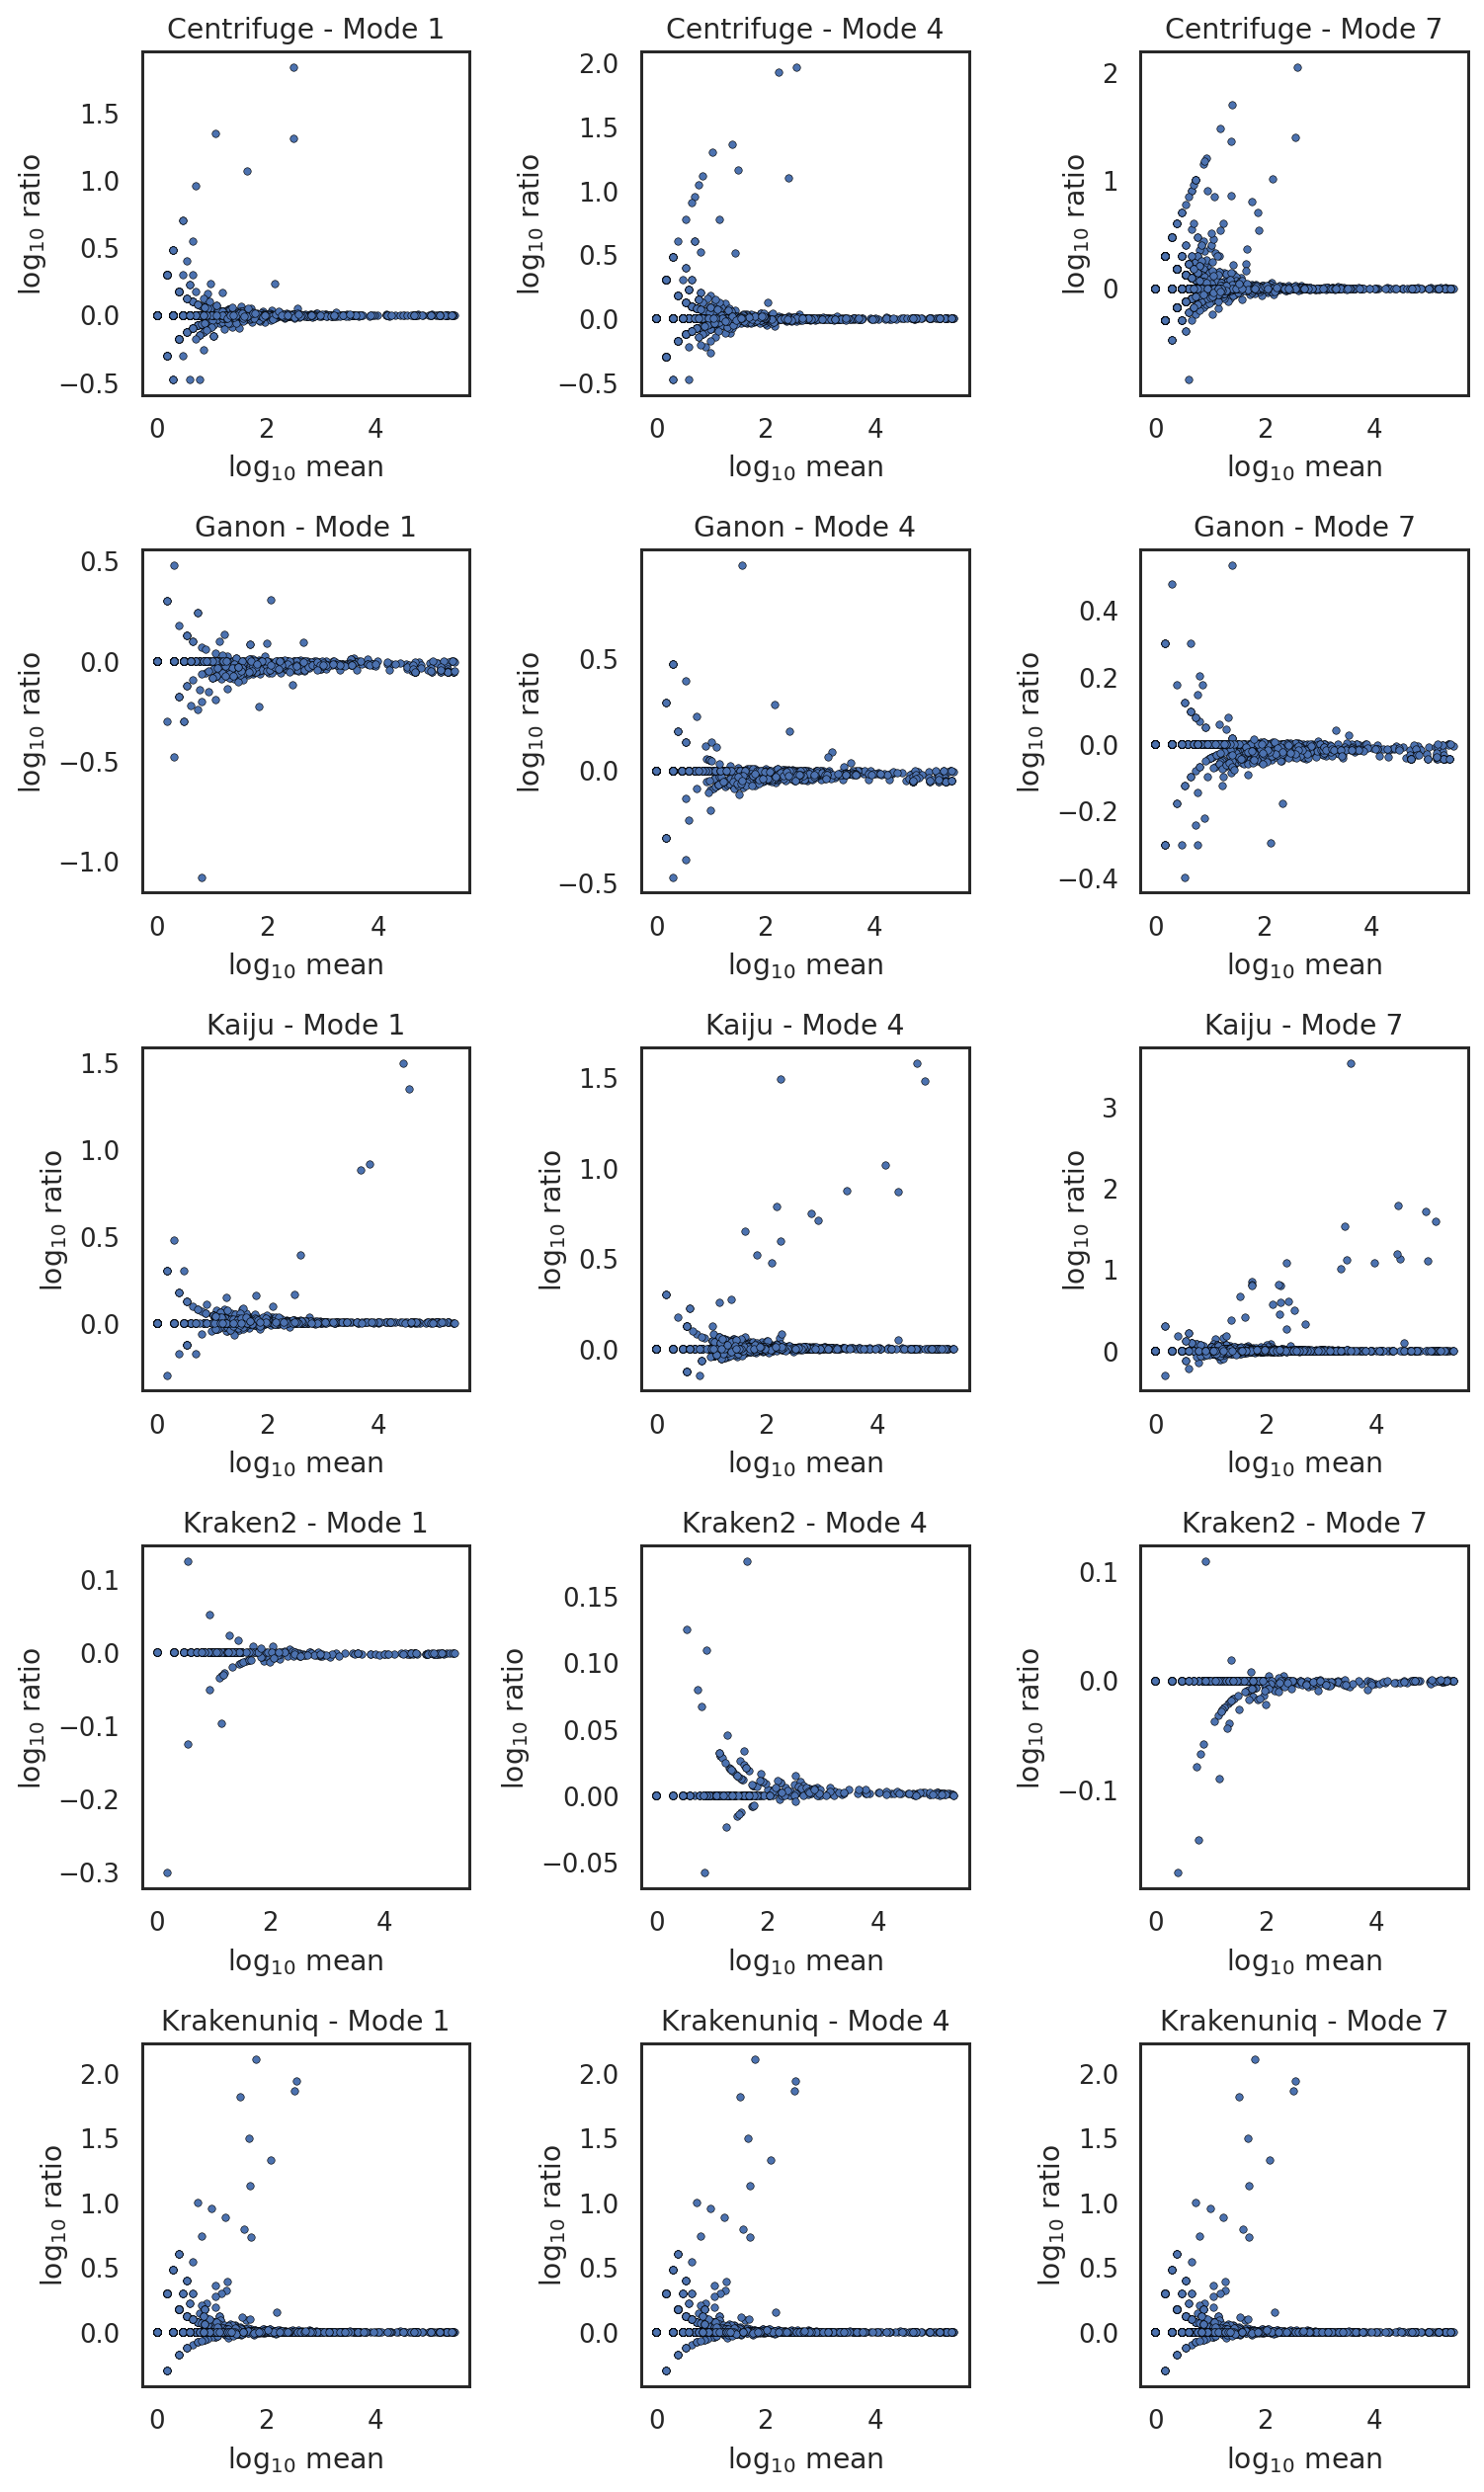

In [ ]:
fig, axes = plt.subplots(5, 3, figsize=(9, 15))
axes = axes.flatten()

# Set Seaborn style
sns.set_theme(style="white")

list_modes = [1, 4, 7]

# Plot for each profiler
for i, profiler in enumerate(LIST_PROFILERS):
    # Filter data for the current profiler and the specified modes 
    df_profiler = df_detailed[(df_detailed['profiler'] == profiler) & (df_detailed['mode'].isin(list_modes))]
    
    # Loop through the modes 
    for j, mode in enumerate(list_modes):
        ax = axes[i * 3 + j]  # Determine the correct axis based on the row and column

        # Filter data for the current mode
        df_mode = df_profiler[df_profiler['mode'] == mode]
        df_mode['logmean'] = np.log10(df_mode['mean'])
        df_mode['logratio'] = np.log10(df_mode['ratio'])
        
        try:
            # Scatter plot for the current mode
            sns.scatterplot(
                data=df_mode, x='logmean', y='logratio', ax=ax, s=10, palette='deep', edgecolor='black'
            )
        except:
            pass
        
        # Configure axis labels and title
        ax.set_xlabel('log$_{10}$ mean')
        ax.set_ylabel('log$_{10}$ ratio')
        ax.set_title(f'{profiler.capitalize()} - Mode {mode}')

# Hide unused axes (if any)
for j in range(len(LIST_PROFILERS) * 3, len(axes)):
    axes[j].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
for profiler in LIST_PROFILERS:
    for mode in (1, 4, 7):
        print(f'PROFILER {profiler} | MODE {mode}')
        df_sub = df_detailed[(df_detailed['profiler'] == profiler) & (df_detailed['mode'] == mode)].copy()
        val = np.log10(df_sub['ratio'].values) ** 2 * np.log10(df_sub['mean'].values)
        df_sub.loc[:, 'xoxo'] = val
        display(df_sub.sort_values(by='xoxo', ascending=False).head(7).iloc[:, :-1])

PROFILER centrifuge | MODE 1


,profiler,mode,name,pass0,pass2,ratio,mean
148,centrifuge,1,Bacillus thuringiensis,614,9,68.222,311.500
234,centrifuge,1,Toxoplasma gondii,588,29,20.276,308.500
232,centrifuge,1,Leishmania infantum,22,1,22.000,11.500
633,centrifuge,1,Alternaria metachromatica,82,7,11.714,44.500
251,centrifuge,1,Puccinia striiformis,9,1,9.000,5.000
813,centrifuge,1,Alternaria incomplexa,5,1,5.000,3.000
1056,centrifuge,1,Leishmania orientalis,5,1,5.000,3.000


PROFILER centrifuge | MODE 4


,profiler,mode,name,pass0,pass2,ratio,mean
4947,centrifuge,4,Bacillus thuringiensis,737,8,92.125,372.500
5533,centrifuge,4,Alternaria metachromatica,336,4,84.000,170.000
5049,centrifuge,4,Toxoplasma gondii,489,39,12.538,264.000
6637,centrifuge,4,Acidovorax sp. BLS4,46,2,23.000,24.000
5053,centrifuge,4,Plasmodium knowlesi,58,4,14.500,31.000
5047,centrifuge,4,Leishmania infantum,20,1,20.000,10.500
5056,centrifuge,4,Plasmodium malariae,13,1,13.000,7.000


PROFILER centrifuge | MODE 7


,profiler,mode,name,pass0,pass2,ratio,mean
11476,centrifuge,7,Bacillus thuringiensis,780,7,111.429,393.500
11650,centrifuge,7,Toxoplasma gondii,702,28,25.071,365.000
11725,centrifuge,7,Neospora caninum,50,1,50.000,25.500
11646,centrifuge,7,Leishmania infantum,30,1,30.000,15.500
12913,centrifuge,7,Aspergillus brunneoviolaceus,46,2,23.000,24.000
11655,centrifuge,7,Plasmodium knowlesi,255,25,10.200,140.000
11640,centrifuge,7,Fusarium oxysporum,16,1,16.000,8.500


PROFILER ganon | MODE 1


,profiler,mode,name,pass0,pass2,ratio,mean
34086,ganon,1,Halorarius halobius,1,12,0.083,6.500
33715,ganon,1,Enterobacter kobei,150,74,2.027,112.000
33587,ganon,1,Corynebacterium glucuronolyticum,52,88,0.591,70.000
33885,ganon,1,Tequatrovirus ar1,1,3,0.333,2.000
33359,ganon,1,Pseudoalteromonas carrageenovora,3,1,3.000,2.000
34122,ganon,1,Streptococcus sp. S5,4,7,0.571,5.500
34131,ganon,1,Streptococcus nidrosiense,7,4,1.750,5.500


PROFILER ganon | MODE 4


,profiler,mode,name,pass0,pass2,ratio,mean
35811,ganon,4,Fusobacterium varium,66,8,8.250,37.000
36040,ganon,4,Citrobacter braakii,200,102,1.961,151.000
36445,ganon,4,Pseudomonas sp. MPDS,2,5,0.400,3.500
36206,ganon,4,Burkholderia lata,5,2,2.500,3.500
36385,ganon,4,Escherichia sp. HH091_1A,329,219,1.502,274.000
36326,ganon,4,Tequatrovirus deeone,3,1,3.000,2.000
36221,ganon,4,Rhizophagus irregularis,3,1,3.000,2.000


PROFILER ganon | MODE 7


,profiler,mode,name,pass0,pass2,ratio,mean
38497,ganon,7,Bacillus thuringiensis,41,12,3.417,26.500
38409,ganon,7,Enterobacter cloacae,91,180,0.506,135.500
38767,ganon,7,Lactobacillus intestinalis,2,5,0.400,3.500
38702,ganon,7,Enterobacter asburiae,180,271,0.664,225.500
38527,ganon,7,Lactobacillus amylovorus,4,8,0.500,6.000
39036,ganon,7,Tequatrovirus deeone,3,1,3.000,2.000
38737,ganon,7,Burkholderia cenocepacia,6,3,2.000,4.500


PROFILER kaiju | MODE 1


,profiler,mode,name,pass0,pass2,ratio,mean
41782,kaiju,1,Corynebacterium amycolatum,54428,1737,31.334,28082.500
41842,kaiju,1,Besnoitia besnoiti,69915,3151,22.188,36533.000
41563,kaiju,1,Neisseria gonorrhoeae,12723,1539,8.267,7131.000
42484,kaiju,1,Acidovorax sp. BLS4,8569,1133,7.563,4851.000
41571,kaiju,1,Klebsiella pneumoniae,561,227,2.471,394.000
42313,kaiju,1,Tequatrovirus pd112,3,1,3.000,2.000
41634,kaiju,1,Clostridium botulinum,365,251,1.454,308.000


PROFILER kaiju | MODE 4


,profiler,mode,name,pass0,pass2,ratio,mean
44896,kaiju,4,Corynebacterium amycolatum,103376,2722,37.978,53049.000
44977,kaiju,4,Besnoitia besnoiti,145222,4781,30.375,75001.500
44695,kaiju,4,Bacillus thuringiensis,343,11,31.182,177.000
44617,kaiju,4,Neisseria gonorrhoeae,26085,2516,10.368,14300.500
45786,kaiju,4,Acidovorax sp. BLS4,42469,5764,7.368,24116.500
44700,kaiju,4,Clostridium botulinum,5074,680,7.462,2877.000
44660,kaiju,4,Staphylococcus aureus,1086,195,5.569,640.500


PROFILER kaiju | MODE 7


,profiler,mode,name,pass0,pass2,ratio,mean
49167,kaiju,7,BeAn 58058 virus,6852,2,3426.000,3427.000
49102,kaiju,7,Corynebacterium amycolatum,153857,3016,51.014,78436.500
48964,kaiju,7,Toxoplasma gondii,48935,803,60.940,24869.000
49225,kaiju,7,Besnoitia besnoiti,232303,6000,38.717,119151.500
48966,kaiju,7,Babesia bigemina,5207,154,33.812,2680.500
48842,kaiju,7,Clostridium botulinum,45035,2926,15.391,23980.500
50412,kaiju,7,Acidovorax sp. BLS4,158467,12495,12.682,85481.000


PROFILER kraken2 | MODE 1


,profiler,mode,name,pass0,pass2,ratio,mean
54061,kraken2,1,Caulobacter sp. FWC26,1,2,0.500,1.500
54025,kraken2,1,Cutibacterium avidum,12,15,0.800,13.500
53983,kraken2,1,Lactiplantibacillus plantarum,3,4,0.750,3.500
54068,kraken2,1,Dorea longicatena,4,3,1.333,3.500
54143,kraken2,1,Verticillium nonalfalfae,8,9,0.889,8.500
54240,kraken2,1,Faecalibacterium sp. i21-0019-B1,9,8,1.125,8.500
53972,kraken2,1,Clostridioides difficile,12,13,0.923,12.500


PROFILER kraken2 | MODE 4


,profiler,mode,name,pass0,pass2,ratio,mean
54992,kraken2,4,Corynebacterium stationis,51,34,1.500,42.500
55193,kraken2,4,Turicimonas muris,9,7,1.286,8.000
55212,kraken2,4,Segatella hominis,4,3,1.333,3.500
55064,kraken2,4,Streptomyces venezuelae,6,5,1.200,5.500
54946,kraken2,4,Streptococcus oralis,7,6,1.167,6.500
55231,kraken2,4,Eponavirus epona,7,8,0.875,7.500
55172,kraken2,4,Streptococcus sp. HSISS3,20,18,1.111,19.000


PROFILER kraken2 | MODE 7


,profiler,mode,name,pass0,pass2,ratio,mean
56138,kraken2,7,Listeria grayi,5,7,0.714,6.000
56180,kraken2,7,Winkia neuii,2,3,0.667,2.500
56395,kraken2,7,Segatella hominis,9,7,1.286,8.000
56193,kraken2,7,Moraxella osloensis,13,16,0.812,14.500
56290,kraken2,7,Bacteroides nordii,5,6,0.833,5.500
56449,kraken2,7,Streptococcus sp. FSL W7-1342,6,7,0.857,6.500
56458,kraken2,7,Paenibacillus sp. G2S3,7,8,0.875,7.500


PROFILER krakenuniq | MODE 1


,profiler,mode,name,pass0,pass2,ratio,mean
57715,krakenuniq,1,Toxoplasma gondii,702,8,87.750,355.000
57558,krakenuniq,1,Bacillus thuringiensis,658,9,73.111,333.500
58347,krakenuniq,1,Punctularia strigosozonata,129,1,129.000,65.000
58404,krakenuniq,1,Neohortaea acidophila,66,1,66.000,33.500
57692,krakenuniq,1,Aspergillus clavatus,94,3,31.333,48.500
57689,krakenuniq,1,Plenodomus lingam,233,11,21.182,122.000
58694,krakenuniq,1,Rhizophagus irregularis,95,7,13.571,51.000


PROFILER krakenuniq | MODE 4


,profiler,mode,name,pass0,pass2,ratio,mean
67069,krakenuniq,4,Toxoplasma gondii,702,8,87.750,355.000
66912,krakenuniq,4,Bacillus thuringiensis,658,9,73.111,333.500
67701,krakenuniq,4,Punctularia strigosozonata,129,1,129.000,65.000
67758,krakenuniq,4,Neohortaea acidophila,66,1,66.000,33.500
67046,krakenuniq,4,Aspergillus clavatus,94,3,31.333,48.500
67043,krakenuniq,4,Plenodomus lingam,233,11,21.182,122.000
68048,krakenuniq,4,Rhizophagus irregularis,95,7,13.571,51.000


PROFILER krakenuniq | MODE 7


,profiler,mode,name,pass0,pass2,ratio,mean
76423,krakenuniq,7,Toxoplasma gondii,702,8,87.750,355.000
76266,krakenuniq,7,Bacillus thuringiensis,658,9,73.111,333.500
77055,krakenuniq,7,Punctularia strigosozonata,129,1,129.000,65.000
77112,krakenuniq,7,Neohortaea acidophila,66,1,66.000,33.500
76400,krakenuniq,7,Aspergillus clavatus,94,3,31.333,48.500
76397,krakenuniq,7,Plenodomus lingam,233,11,21.182,122.000
77402,krakenuniq,7,Rhizophagus irregularis,95,7,13.571,51.000



**What do we see here?**
- The number of reads assigned to different species increases considerably with less specific profiler parameters. However, it is interesting to note that the Jaccard index between passes 0 and 2 is incredibly high, even for the less specific profiler parameters. This means that the species selection is similar regardless of if a previous mapping to the host was performed.
- Moreover, if we look at the ratio of reads assigned to species between passes 0 and 2 we see that, in general, the ratio of reads assigned is 1, that is, the number of reads assigned for each species is the same regardless of the pass. 
    - This effect is less pronounced with species with lower abundances (up to ~ 100 reads), where the ratio fluctuates. For centrifuge, more reads tend to be assigned in pass 0.
    - There are some exceptions, notably for kaiju, but also in centrifuge and ganon, where species with a higher number of reads are assigned more reads in pass 0, such as *Bacillus thuringiensis*, *Toxoplasma gondii*, *Alternaria metachromatica*, *Enterobacter kobei*, *Corynebacterium amycolatum*, *Besnoitia besnoiti*, *Neisseria gonorrhoeae*. In all these cases the number of reads is reduced 2-10 times.

Therefore, although marginally, performing host mapping may favour a better species recognition.

In [ ]:
subset_df = df_numerical_stats[(df_numerical_stats['pass'].isin([2])) & \
                               (df_numerical_stats['profiler'].isin(LIST_PROFILERS + ['mean'])) & \
                               (df_numerical_stats['mode'].isin(range(2, 9)))]

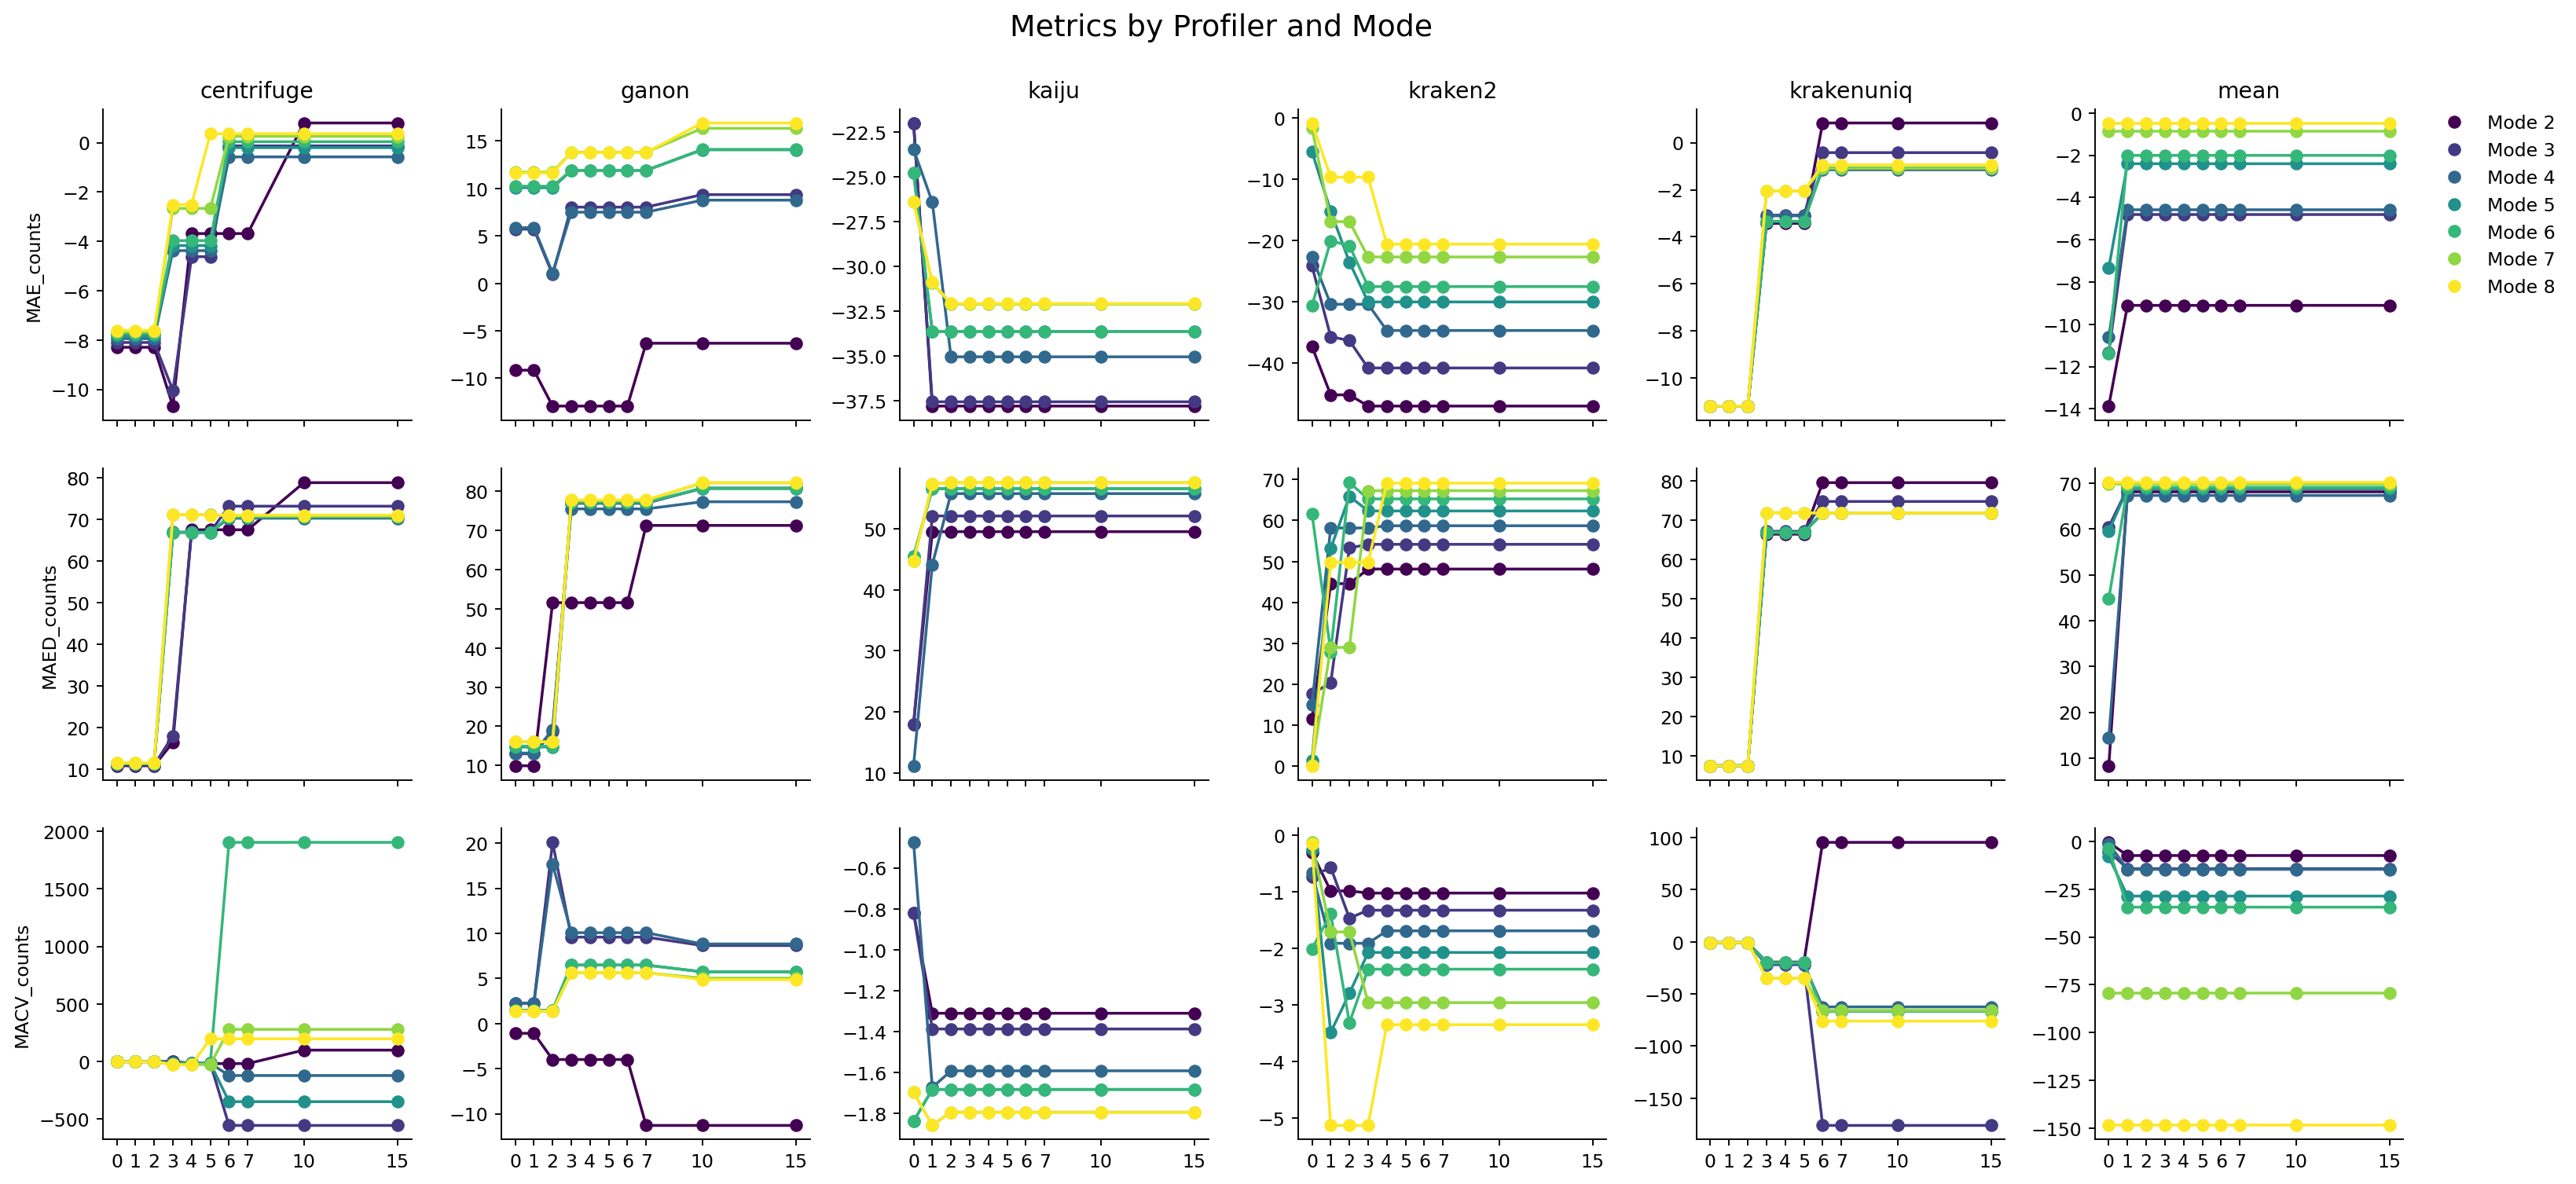

In [ ]:
melted_df = pd.melt(
    subset_df,
    id_vars=['mode', 'S', 'profiler'],
    value_vars=['MAE_counts', 'MAED_counts', 'MACV_counts'],
    var_name='metric',
    value_name='score'
)

# Create a colormap for 'mode'
norm = Normalize(vmin=melted_df['mode'].min(), vmax=melted_df['mode'].max())
cmap = plt.cm.viridis  # Choose a colormap (e.g., 'viridis', 'plasma', 'cividis')

# Create a FacetGrid: 6x3 grid (row for each profiler, column for each metric)
g = sns.FacetGrid(
    melted_df, 
    col='profiler', 
    row='metric', 
    height=3, 
    sharey=False, 
    sharex=True
)

# Map the lineplot to the grid
def lineplot_with_cmap(data, **kwargs):
    for mode in sorted(data['mode'].unique()):
        subset = data[data['mode'] == mode]
        plt.plot(subset['S'], subset['score'], label=f"Mode {mode}",
                color=cmap(norm(mode)), marker='o')

g.map_dataframe(lineplot_with_cmap)

# Create a legend for the discrete modes
handles = [
    plt.Line2D([0], [0], color=cmap(norm(mode)), marker='o', linestyle='', label=f"Mode {mode}")
    for mode in sorted(melted_df['mode'].unique())
]
plt.legend(
    handles=handles, 
    title="", 
    bbox_to_anchor=(1.05, 3), 
    loc='center left', 
    frameon=False
)

# Set x-axis ticks (if you have specific S values)
g.set(xticks=subset_df['S'].unique())

for ax in g.axes.ravel():
    ax.set_title('')

# Add axis labels and titles
for ax, profiler in zip(g.axes[0, :], melted_df['profiler'].unique()):
    ax.set_title(profiler.replace('_norm', ''))

for ax, score in zip(g.axes[:, 0], ['MAE_counts', 'MAED_counts', 'MACV_counts']):
    ax.set_ylabel(score)

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Metrics by Profiler and Mode", fontsize=16)

plt.show()

/home/neuroimm/.local/share/mamba/envs/EVs/lib/python3.13/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


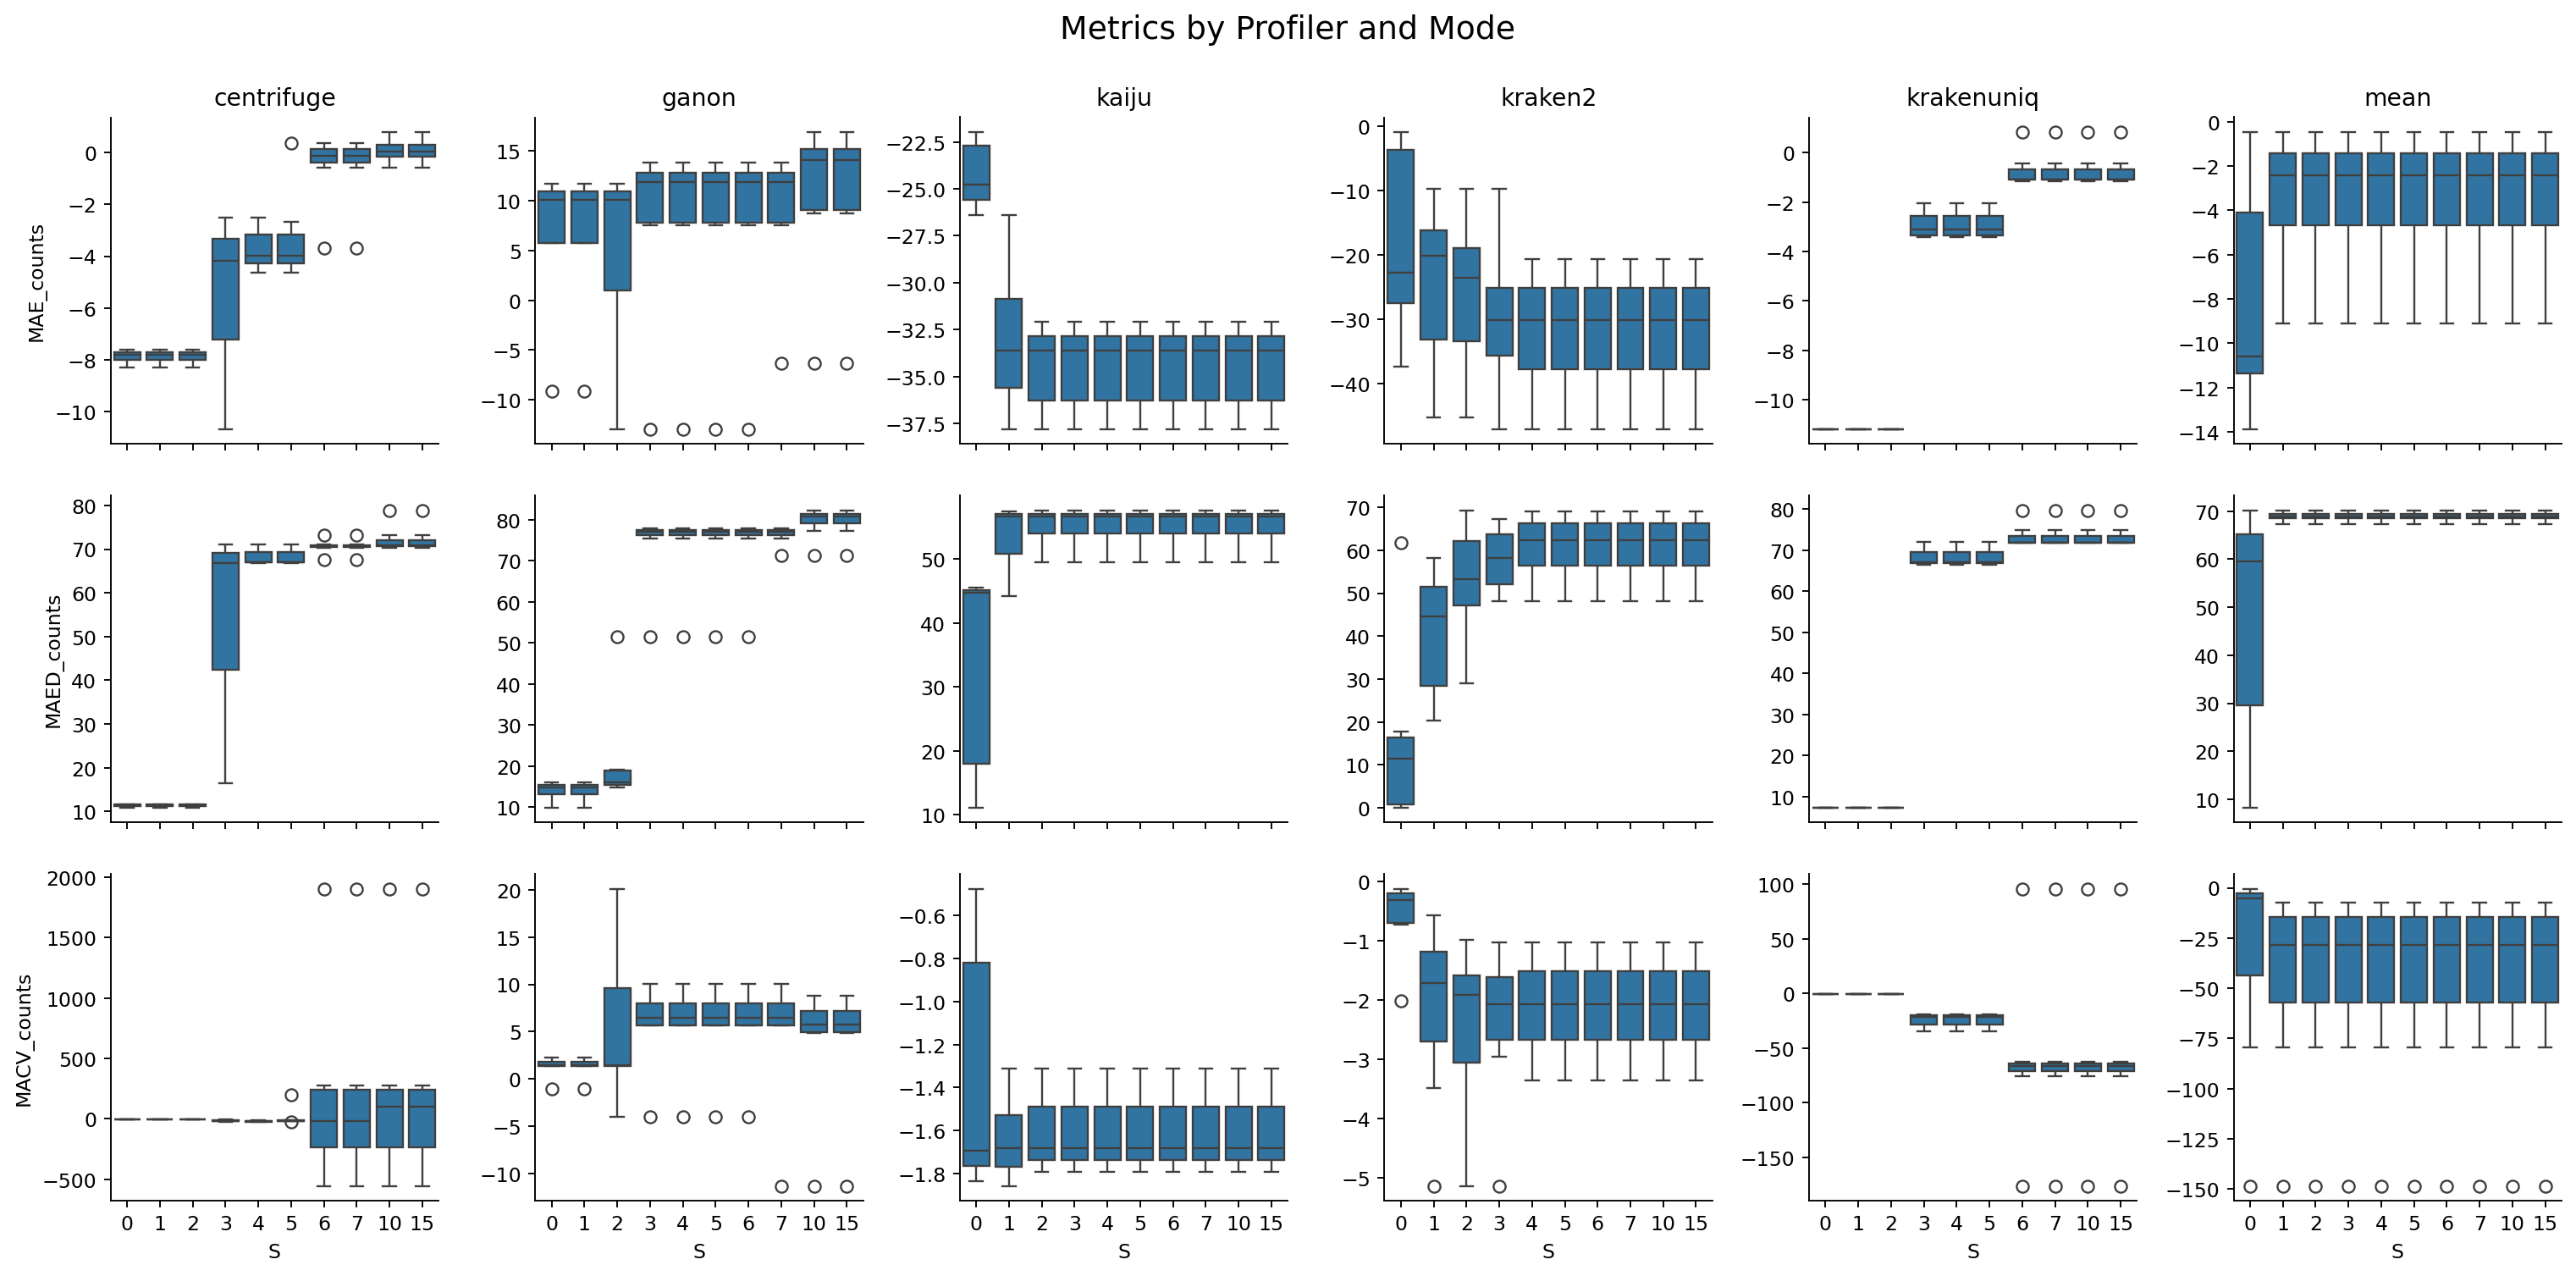

In [ ]:
g = sns.FacetGrid(
    melted_df, 
    col='profiler', 
    row='metric', 
    height=3, 
    sharey=False, 
    sharex=True
)

g.map(sns.boxplot, 'S', 'score')

# Set x-axis ticks (if you have specific S values)
for ax in g.axes.ravel():
    ax.set_title('')

# Add axis labels and titles
for ax, profiler in zip(g.axes[0, :], melted_df['profiler'].unique()):
    ax.set_title(profiler.replace('_norm', ''))

for ax, score in zip(g.axes[:, 0], ['MAE_counts', 'MAED_counts', 'MACV_counts']):
    ax.set_ylabel(score)

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Metrics by Profiler and Mode", fontsize=16)

plt.show()